In [1]:
import networkx as nx
from GraphGenusGenerator import GraphGenusGenerator
from HC_Algorithm import hill_climb

In [2]:
seed=132456
problem = GraphGenusGenerator().generate(seed=seed, number_of_nodes=5, max_connections_per_node=3, complete_graph=True)

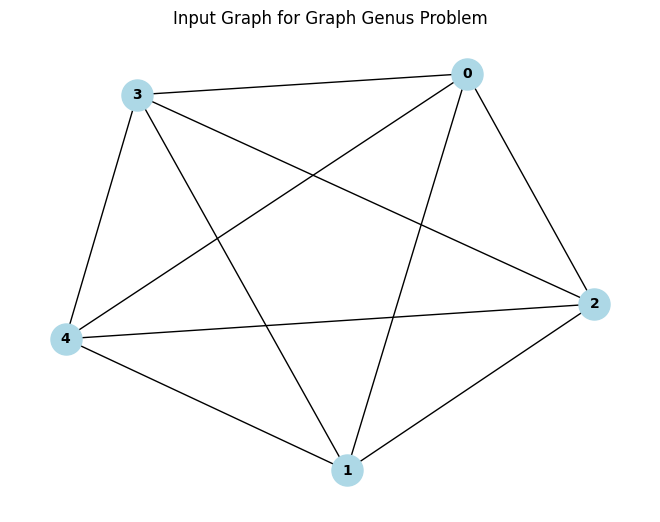

In [3]:
# Get the adjacency list (which is a graph object)
adj_list = problem.adj_list
graph = nx.Graph(adj_list)

# Draw the generated graph
import matplotlib.pyplot as plt
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
plt.title("Input Graph for Graph Genus Problem")
plt.show()

In [4]:
print(hill_climb(problem=problem, max_iter=1000, seed=seed))


start fitness 2
[3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2]
2
0 2 {0: [4, 1, 2, 3], 1: [0, 2, 3, 4], 2: [0, 1, 3, 4], 3: [0, 1, 2, 4], 4: [0, 1, 2, 3]}
[2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2]
2
1 2 {0: [3, 2, 4, 1], 1: [0, 2, 3, 4], 2: [0, 1, 3, 4], 3: [0, 1, 2, 4], 4: [0, 1, 2, 3]}
[2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 2]
2
2 2 {0: [1, 4, 3, 2], 1: [0, 2, 3, 4], 2: [0, 1, 3, 4], 3: [0, 1, 2, 4], 4: [0, 1, 2, 3]}
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
2
3 2 {0: [2, 3, 4, 1], 1: [4, 3, 2, 0], 2: [4, 3, 1, 0], 3: [4, 1, 0, 2], 4: [0, 1, 2, 3]}
[2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
2
4 2 {0: [1, 4, 3, 2], 1: [0, 2, 3, 4], 2: [0, 1, 3, 4], 3: [1, 4, 0, 2], 4: [0, 1, 2, 3]}
[3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2,